# Rap1 Negative Selection Time Course

## Imports and Locating Data

In [1]:
import sys
import os
import subprocess
import shlex
import pandas as pd
import numpy as np
import colorsys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib_venn as v
import itertools
import seaborn as sns
from itertools import combinations
from collections import defaultdict
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

%matplotlib inline

In [2]:
def DataTable(df):
    # I got this from http://blog.dornea.nu/2014/08/28/using-jquery-datatables-with-ipython/
    """ Prints a pandas.DataFrame as JQuery DataTables """
    # Generate random container name
    from IPython.display import HTML
    import uuid
    import qgrid
    id_container = uuid.uuid1()
    output = """
        <div id="datatable-container-%s">
            <link rel="stylesheet" type="text/css" href="http://ajax.aspnetcdn.com/ajax/jquery.dataTables/1.9.0/css/jquery.dataTables.css">
            <link rel="stylesheet" type="text/css" href="http://ajax.aspnetcdn.com/ajax/jquery.dataTables/1.9.0/css/jquery.dataTables_themeroller.css">
            <script type="text/javascript" charset="utf8" src="http://ajax.aspnetcdn.com/ajax/jquery.dataTables/1.9.0/jquery.dataTables.min.js"></script>

            <script type="text/javascript">
                var url = window.location.href;
                
                if(url.indexOf("localhost:9999") != -1){
                    $('#datatable-container-%s table.datatable').dataTable();
                } else {
                    $.getScript("http://code.jquery.com/jquery-1.11.1.min.js");
                    $(document).ready(function() {
                        $('#datatable-container-%s table.datatable').dataTable();
                    });
                }
                
            </script>
            <!-- Insert table below -->
            %s
        </div>
    """ % (id_container, id_container, id_container, df.to_html(index=False, classes="datatable dataframe"))
    return HTML(output)

Here I clone one of the main python classes that I use across projects. It defines a Fastq object and SimrFastq object that inherits from the Fastq object. These are used in the SimrData class, which gathers information on sequencing data from the Stowers file system. I display the entire python script in the cell below for future reference.

In [3]:
%%bash
cd ../bin
#git clone https://github.com/DuncanTormey/fastq_class.git
cd fastq_class
cat fastq_class.py

#!/usr/bin/env python
#Author: Duncan Tormey
#Email: dut@stowers.org or duncantormey@gmail.com

from __future__ import print_function
import os
import re
import glob
import pandas as pd
from pprint import pprint

def read_list_file(path):
    l = list(set(open(path.strip('\n'), 'r').read().strip('\n').splitlines()))
    return l

class Fastq(object):
    def __init__(self, fastq_path):
        self.path = fastq_path
        self.file_name = os.path.basename(self.path)
        if re.match('s_[0-9]+_[0-9]+_', self.file_name[:6]):
            self.lane = self.file_name[2]
            self.pair = self.file_name[4]

    def __repr__(self):
        return self.path


class SimrFastq(Fastq):
    def __init__(self, fastq_path, sample_report_path):
        super(SimrFastq, self).__init__(fastq_path)
        self.flowcell = sample_report_path.split('/')[-2]
        self.sample_report_path = sample_report_path
        self.sr_df = pd.read_csv(self.sample_report_path)
        self.sr_df.columns = 

Modify python path to include my local module.

In [4]:
sys.path = ['../bin/fastq_class/'] + sys.path
import fastq_class as lims

Read in the sample report generated by LIMs.

In [5]:
sample_report3 = pd.read_csv("/n/analysis/Baumann/lpn/MOLNG-1608/HKK57BCXXa/Sample_Report.csv")
DataTable(sample_report3)

output,order,order type,lane,sample name,library id,illumina index,custom barcode,read,reference,lab,total reads,pass filter reads,pass filter percent,align percent,type,read length
s_1_1_AGGCAGAA-AAGGAGTA.fastq.gz,MOLNG-1608,DNA-Seq Nextera (1ng),1,C_R4,L22273,AGGCAGAA-AAGGAGTA,NaN,1,pombe_ASM294v2,Baumann Lab,381905,381905,100.0,85.18,single,101
s_1_1_AGGCAGAA-ACTGCATA.fastq.gz,MOLNG-1608,DNA-Seq Nextera (1ng),1,B_R4,L22272,AGGCAGAA-ACTGCATA,NaN,1,pombe_ASM294v2,Baumann Lab,375292,375292,100.0,88.46,single,101
s_1_1_AGGCAGAA-AGAGTAGA.fastq.gz,MOLNG-1608,DNA-Seq Nextera (1ng),1,C_R3,L22270,AGGCAGAA-AGAGTAGA,NaN,1,pombe_ASM294v2,Baumann Lab,361759,361759,100.0,87.50,single,101
s_1_1_AGGCAGAA-CTAAGCCT.fastq.gz,MOLNG-1608,DNA-Seq Nextera (1ng),1,A_R5,L22274,AGGCAGAA-CTAAGCCT,NaN,1,pombe_ASM294v2,Baumann Lab,304873,304873,100.0,85.73,single,101
s_1_1_AGGCAGAA-CTCTCTAT.fastq.gz,MOLNG-1608,DNA-Seq Nextera (1ng),1,A_R3,L22268,AGGCAGAA-CTCTCTAT,NaN,1,pombe_ASM294v2,Baumann Lab,399834,399834,100.0,86.24,single,101
s_1_1_AGGCAGAA-GCGTAAGA.fastq.gz,MOLNG-1608,DNA-Seq Nextera (1ng),1,C_R2,L22267,AGGCAGAA-GCGTAAGA,NaN,1,pombe_ASM294v2,Baumann Lab,528415,528415,100.0,88.15,single,101
s_1_1_AGGCAGAA-GTAAGGAG.fastq.gz,MOLNG-1608,DNA-Seq Nextera (1ng),1,A_R4,L22271,AGGCAGAA-GTAAGGAG,NaN,1,pombe_ASM294v2,Baumann Lab,333978,333978,100.0,90.05,single,101
s_1_1_AGGCAGAA-TATCCTCT.fastq.gz,MOLNG-1608,DNA-Seq Nextera (1ng),1,B_R3,L22269,AGGCAGAA-TATCCTCT,NaN,1,pombe_ASM294v2,Baumann Lab,410463,410463,100.0,85.22,single,101
s_1_1_CGTACTAG-AAGGAGTA.fastq.gz,MOLNG-1608,DNA-Seq Nextera (1ng),1,A_R2,L22265,CGTACTAG-AAGGAGTA,NaN,1,pombe_ASM294v2,Baumann Lab,259704,259704,100.0,86.10,single,101
s_1_1_CGTACTAG-ACTGCATA.fastq.gz,MOLNG-1608,DNA-Seq Nextera (1ng),1,C_R1,L22264,CGTACTAG-ACTGCATA,NaN,1,pombe_ASM294v2,Baumann Lab,428965,428965,100.0,87.31,single,101


Summarize the number of reads per sample

In [6]:
read_summary = sample_report3.groupby('sample name').sum().drop(['XYZ_R0']).reset_index()[['sample name','total reads']]
read_summary.to_csv('../data/tables/read_counts.csv')
DataTable(read_summary)

sample name,total reads
ABC_R0,382374
A_R1,751714
A_R2,529933
A_R3,813649
A_R4,681322
A_R5,620881
B_R1,732036
B_R2,560009
B_R3,833834
B_R4,763065


Define variables needed for SimrData object generation

In [7]:
molngs = ['/n/analysis/Baumann/lpn/MOLNG-1608/']
flowcells = ["HKK57BCXXa"]
samples = sample_report3["sample name"].tolist()
samples = list(set(samples))


Save list sample names for time course samples only. This is used later

In [8]:
time_course_samples = [sample for sample in samples if "A" in sample or "B"in sample or "C" in sample]


Save list sample names for pre-time-course libraries only. This is used later

In [9]:
starting_samples = ["ABC_R0", "Mut_lib_plasmid"]

Save variables for trimmomatic command. This is the generic command string parameters that is shown in the reference manual. The software can be easily be downloaded here: http://www.usadellab.org/cms/?page=trimmomatic

In [10]:
trimmomatic = '/home/dut/bin/trinityrnaseq-2.0.6/trinity-plugins/Trimmomatic/trimmomatic-0.32.jar'
trim_param = 'ILLUMINACLIP:/home/dut/bin/trinityrnaseq-2.0.6/trinity-plugins/Trimmomatic/adapters/NexteraPE-PE.fa:2:30:10 LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36'

Save a couple of variables for generating the alignments and final tables.

In [11]:
reference = '../data/fasta/lili_PCR_for_NGS.fasta'
alignment_outdir = '../data/alignments'
tables_outdir = '../data/tables'

Initilize SimrData object and make sure only desired flowcell is selected.

In [12]:
data = lims.SimrData(samples,molngs)
data.select_flowcells(flowcells)


selecting data from flowcells:
['HKK57BCXXa']


Display attribute used by alignment functions

In [13]:
data.sample_fastqs

{'ABC_R0': [/n/analysis/Baumann/lpn/MOLNG-1608//HKK57BCXXa/s_1_1_CGTACTAG-CTCTCTAT.fastq.gz,
  /n/analysis/Baumann/lpn/MOLNG-1608//HKK57BCXXa/s_2_1_CGTACTAG-CTCTCTAT.fastq.gz],
 'A_R1': [/n/analysis/Baumann/lpn/MOLNG-1608//HKK57BCXXa/s_2_1_CGTACTAG-AGAGTAGA.fastq.gz,
  /n/analysis/Baumann/lpn/MOLNG-1608//HKK57BCXXa/s_1_1_CGTACTAG-AGAGTAGA.fastq.gz],
 'A_R2': [/n/analysis/Baumann/lpn/MOLNG-1608//HKK57BCXXa/s_1_1_CGTACTAG-AAGGAGTA.fastq.gz,
  /n/analysis/Baumann/lpn/MOLNG-1608//HKK57BCXXa/s_2_1_CGTACTAG-AAGGAGTA.fastq.gz],
 'A_R3': [/n/analysis/Baumann/lpn/MOLNG-1608//HKK57BCXXa/s_1_1_AGGCAGAA-CTCTCTAT.fastq.gz,
  /n/analysis/Baumann/lpn/MOLNG-1608//HKK57BCXXa/s_2_1_AGGCAGAA-CTCTCTAT.fastq.gz],
 'A_R4': [/n/analysis/Baumann/lpn/MOLNG-1608//HKK57BCXXa/s_2_1_AGGCAGAA-GTAAGGAG.fastq.gz,
  /n/analysis/Baumann/lpn/MOLNG-1608//HKK57BCXXa/s_1_1_AGGCAGAA-GTAAGGAG.fastq.gz],
 'A_R5': [/n/analysis/Baumann/lpn/MOLNG-1608//HKK57BCXXa/s_1_1_AGGCAGAA-CTAAGCCT.fastq.gz,
  /n/analysis/Baumann/lpn/MOLNG-

## Alignment/Pysam Commands

Below are the functions used to run the trimming, aligning and conversion of alignments to per-position base composition.

In [14]:
def ret_merge_single_bwa_align_cmd(sample, fastqs, outdir, cpus, fasta_ref_path,trimmomatic, trim_param, verbose=False):
    '''
    This function generates a command script to trim reads, 
    align reads, merge alignments, and filter alignments.
    The function returns the command as a string and the 
    path to the output file generated by the command.
    
    This fuctio n takes as input:
    sample      --> sample name (str) 
    fastqs      --> a list of fastq objects corresponding to the sample  
    outdir      --> the path to a desired output directory (str)
    cpus        --> the number of cpus to use (int)
    fasta_ref   --> a path to the alignment reference (str)  
    trimmomatic --> path to a trimmomatic executable (str)
    trim_params --> the string of parameters taken by  trimmomatic (str).
    verbose     --> boolean, if true prints all parameters passed(locals()) 
                    and prints the returned variables. Else prints nothing
    
    Example Execution With verbose = True:
    >>>ret_merge_single_bwa_align_cmd(sample, fastqs, outdir, cpus, fasta_ref_path, 
    trimmomatic, trim_param, verbose=True)
    
    {'verbose': True, 'fasta_ref_path': '../data/fasta/lili_PCR_for_NGS.fasta', 
    'cpus': 16, 
    'sample': 'C_R4', 
    'fastqs': [<lims_classes.Fastq object at 0x7ff0e0ac0e90>, <lims_classes.Fastq object at 0x7ff0e09f7790>], 
    'trim_param': 'ILLUMINACLIP:NexteraPE-PE.fa:2:30:10 LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36', 
    'trimmomatic': '/home/dut/bin/trinityrnaseq-2.0.6/trinity-plugins/Trimmomatic/trimmomatic-0.32.jar', 
    'outdir': '../data/alignments'}
    ----------------------------------------------------------------------------------------------------
    (cat /n/analysis/Baumann/lpn/MOLNG-1608/HKK57BCXXa/s_1_1_AGGCAGAA-AAGGAGTA.fastq.gz \
    /n/analysis/Baumann/lpn/MOLNG-1608/HKK57BCXXa/s_2_1_AGGCAGAA-AAGGAGTA.fastq.gz > \
    ../data/alignments/C_R4.fastq.gz; \
    java -jar /home/dut/bin/trinityrnaseq-2.0.6/trinity-plugins/Trimmomatic/trimmomatic-0.32.jar SE \
    -threads 8 ../data/alignments/C_R4.fastq.gz ../data/alignments/C_R4.trimmed.fastq.gz \
    ILLUMINACLIP:NexteraPE-PE.fa:2:30:10 LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36 &> \
    ../data/alignments/C_R4.trimmed.out; bwa mem -M -t 16 ../data/fasta/lili_PCR_for_NGS.fasta \
    ../data/alignments/C_R4.trimmed.fastq.gz | samtools view -Sbq 2 -@ 16 - | samtools sort -@ 16 \
    -T C_R4_temp > ../data/alignments/C_R4.bam; samtools index ../data/alignments/C_R4.bam)

    ----------------------------------------------------------------------------------------------------
    ../data/alignments/C_R4.bam
    '''
    if verbose:
        print(locals())
        print('-'*100)
    cpus = str(cpus)
    fastqs = ' '.join((fq.path for fq in fastqs))
    

    fastq = '%s/%s.fastq.gz' % (outdir, sample)

    trimmed_fastq = fastq.replace('.fastq.gz', '.trimmed.fastq.gz')

    merge = 'cat %s > %s' % (fastqs, fastq)

    trim = 'java -jar %s SE -threads 8 %s %s %s &> %s' % (
        trimmomatic, 
        fastq, 
        trimmed_fastq,
        trim_param, 
        trimmed_fastq.replace('.fastq.gz', '.out'))
    output_bam = '%s/%s.bam' % (outdir, sample)

    bwa_command = "bwa mem -M -t %s %s %s" % (cpus,
                                              fasta_ref_path,
                                              trimmed_fastq,
                                              )

    sam_to_sorted_bam = ('samtools view -Sbq 2 -@ %s - | '
                         'samtools sort -@ %s -T %s > %s; samtools index %s') % (cpus, 
        cpus, sample + '_temp', output_bam, output_bam)

    align_sort_cmd = "(%s; %s; %s | %s)\n" % (
        merge, 
        trim, 
        bwa_command, 
        sam_to_sorted_bam)
    
    if verbose:
        print(align_sort_cmd)
        print('-'*100)
        print(output_bam)
    
    return align_sort_cmd, output_bam

In [15]:
def ret_pysamstats_cmd(sample, alignment, outdir, fasta_ref_path):
    '''
    This function generates a pysamstats command for alignment file.
    The resultin tsv file will have columns corresponding to the fields variable:
    chrom,pos,ref,reads_all,matches,mismatches,deletions,insertions,A,C,T,G,N.
    The function returns the command as a str and the path to the resulting table as a str.
    
    The function takes as input:
    sample         --> sample name (str)
    alignment      --> path to alignment file (str)
    outdir         --> path to output directory
    fasta_ref_path --> path to the fasta file that the alignment used for a reference.
    
    '''
    
    output_table = '%s/%s_position_data.tsv' % (outdir, sample)
    fields = 'chrom,pos,ref,reads_all,matches,mismatches,deletions,insertions,A,C,T,G,N'
    cmd = "pysamstats -f %s --type variation --pad -D 100000000 --fields=%s %s | tr -d \'\\r\'> %s" % (fasta_ref_path, fields, alignment, output_table)

    return cmd, output_table

In [16]:
def align_from_single_lims_report(data, outdir, reference, trimmomatic, trim_param, verbose=False):
    '''
    This function uses the ret_merge_single_bwa_align_cmd and the subprocess module to 
    run the generated alignment commands for each sample in a SimrData object.
    
    The function takes as input:
    data        --> SimrData object containg data for the samples you want to align
    outdir      --> path to output directory (str)
    reference   --> path to the fasta file that was used to create a index for the alignment.
                    The index prefix must be the name of the fasta file and the fasta file 
                    must be in the same directory. (str)
    trimmomatic --> path to the trimmomatic exicutable (str)
    trim_param  --> the string of parameters taken by  trimmomatic (str)
    verbose     --> boolean, if true prints all parameters passed(locals()) 
                    and prints the returned variables. Else prints nothing
    
    The function returns:
    alignments --> a dictionary of paths to alignments where the key is the sample name.
    '''
    
    alignments = {}
    for sample in data.sample_fastqs:
        command, alignment = ret_merge_single_bwa_align_cmd(sample,
                                                            data.sample_fastqs[
                                                                sample],
                                                            outdir,
                                                            16,
                                                            reference,
                                                            trimmomatic,
                                                            trim_param,
                                                            verbose=verbose)
        alignments[sample] = alignment
        if not os.path.exists(alignment):
            print(command)
            subprocess.call(command,shell=True)

    return alignments

In [17]:
def ret_position_tables_from_alignments(alignments, outdir, fasta_ref_path):
    '''
    This function uses the ret_pysamstats_cmd function and the subprocess module
    to run pysamstats commands on a dictionary of alignments(key = sample name, 
    val = path to alignment) and generate a dictionary of paths to the tables 
    generated by the pysamstats commands.
    
    The function takes as input:
    
    outdir     --> path to output directory (str)
    reference  --> path to the fasta file that was used to create a index for the alignment.
                   The index prefix must be the name of the fasta file and the fasta file 
                   must be in the same directory. (str)
    alignments --> a dictionary of paths to alignments where the keys are the sample names.
    
    The function returns:
    position_data_tables --> a dictionary of paths to tables where the keys are the sample names.
    
    
    '''
    position_data_tables = {}
    for sample in alignments:
        command, position_data_table = ret_pysamstats_cmd(
            sample, alignments[sample], outdir, fasta_ref_path)
        position_data_tables[sample] = position_data_table
        
        if not os.path.exists(position_data_table):
            print(command)
            subprocess.call(command,shell=True)
            
    return position_data_tables

## Data Frame Manipulations

This section contains the function used to manipulate the tables output by pysamstats.

In [18]:
def norm_position_df(position_df):
    '''
    Converts read counts for each catagory into percentage of reads aligned at that position.
    
    Inputs:
    position_df --> pandas dataframe of table output by pysamstats.
    
    Outputs:
    normed_df   --> pandas dataframe of table output by pysamstats, with percentages 
                    instead of read counts
    
    '''
    
    columns_to_norm = ['matches', 'mismatches',
                       'deletions', 'insertions', 'A', 'T', 'C', 'G', 'N']
    non_normed = [x for x in position_df.columns if x not in columns_to_norm]
    normed_columns = position_df[columns_to_norm].divide(position_df['reads_all'], axis='rows')
    normed_columns = normed_columns * 100
    
    normed_df = pd.concat([position_df[non_normed], normed_columns], 
                          axis=1,
                          join_axes=[position_df.index])
    return normed_df

In [19]:
def merge_data_frames(position_data_tables, sample_list, 
                      dropped=['chrom', 'pos', 'ref'], merged_df=pd.DataFrame()):
    """
    Merges all samples pysamstats data frames corresponding to a list of sample names
    into a single dataframe. Columns are modified to include sample names.
    
    Inputs:
    position_data_tables --> a dictionary of paths to tables where the keys are the sample names.
    sample_list          --> List of sample names to merg into single dataframe
    dropped              --> drop these columns for all individual tables.
    merged_df            --> If you want to merge df into a existing dataframe then modify this 
                             argument to be that dataframe. Defaults to empty
    
    Outputs:
    merged_df            --> pandas DataFrame of merged samples.
    
    
    """
    
    for sample in sample_list:
        sample_df = pd.read_csv(position_data_tables[sample], sep='\t')
        sample_df = norm_position_df(sample_df)
        if merged_df.empty:
            sample_df.columns = ['%s-%s' % (
                sample, x) if x not in dropped else x for x in sample_df.columns]
            merged_df = sample_df
        else:
            sample_df.drop(dropped, axis=1, inplace=True)
            sample_df.columns = ['%s-%s' %
                                 (sample, x) for x in sample_df.columns]
            merged_df = pd.concat([merged_df, sample_df],
                                  axis=1, join_axes=[merged_df.index])
    return merged_df

In [20]:
def compute_deltas(merged_df, global_columns=['chrom', 'pos', 'ref']):
    '''
    #this function currently isnt used in this version of the analysis.
    
    Takes a merged dataframe of time course samples and computes the difference
    between each time point for all none "global" columns. This function is very 
    specific to the sample names in this experiment.
    
    Inputs:
    merged_df      --> merged data frame output by merge_data_frames, with samples 
                       specific to a time course
    global_columns --> List of column names that you do not want to compute deltas for.
    
    Outputs:
    merged_df      --> merged df with additional columns corresponding to change from one round to 
                       the next.
    
    '''
    
    # sample suffixes in this case, designate the replicate
    sample_suffixes = list(set([x.split('_')[0] for x in merged_df.columns]))
    print(sample_suffixes)
    fields = list(set([x.split('-')[-1]
                       for x in merged_df.columns if x not in global_columns]))
    for sample in sample_suffixes:
        sample_columns = [x for x in merged_df.columns if x.split('_')[
            0] == sample]
        for field in fields:
            sample_fields = [
                x for x in sample_columns if x.split('-')[-1] == field]
            sample_fields = sorted(sample_fields,
                                   key=lambda x: int(x.split('_')[1][1]),
                                   reverse=True)
            combos = combinations(sample_fields, 2)
            for combo in combos:
                rnd1 = combo[0].split('-')[0].split('_')[-1]
                rnd2 = combo[1].split('-')[0].split('_')[-1]

                key = '%s_%s%s-d_%s' % (sample, rnd2, rnd1, field)
                merged_df[key] = merged_df[combo[1]] - merged_df[combo[0]]
                key = '%s_%s%s-fc_%s' % (sample, rnd2, rnd1, field)
                merged_df[key] = merged_df[combo[1]] / merged_df[combo[0]]

    return merged_df

In [21]:
def make_round_zero_comparisons(merged_df, rnd, samples=['A', 'B', 'C']):
    '''
    This function calculates the fold change between a given round and round 5 across
    replicates. It then averages the fold change between replicates and calculates the 
    standard deviation.
    
    Inputs:
    merged_df --> merged data frame output by merge_data_frames, with samples 
                  specific to a time course
    rnd       --> The round to compare to round 5 (int)
    samples   --> Which replicates you want to average (list)
    
    Outputs:
    merged_df --> merged data frame output by merge_data_frames, with samples 
                  specific to a time course. now with added columns
    mean      --> the name of the avg fold change column
    std       --> the name of the std dev column
    '''
    
    fc_cols = []
    for s in samples:
        r1 = 'ABC_R0-mismatches'
        r2 = '%s_R%s-mismatches' % (s,str(rnd))
        fc = '%s_R0R%s-fc_mismatches' % (s,str(rnd))
        fc_cols.append(fc)
        merged_df[fc] = (merged_df[r1] / merged_df[r2])
    mean = 'avg_R0R%s-fc_mismatches' % str(rnd)
    std = 'std_R0R%s-fc_mismatches' % str(rnd)
    ste = 'ste_R0R%s-fc_mismatches' % str(rnd)
    
    merged_df[mean] = merged_df[fc_cols].replace(-np.inf, np.nan).mean(axis=1, skipna=True)
    merged_df[std] = merged_df[fc_cols].replace(-np.inf, np.nan).std(axis=1, skipna=True)
    merged_df[ste] = merged_df[std]/np.sqrt(len(samples))

    return merged_df, mean, ste

In [22]:
def make_subset_df(merged_df, kept_columns, avg_column_regexs, positions):
    '''
    This function generates a new dataframe from a merged dataframe based on
    a list of columns from a merged_df. It then averages columns together 
    based on a regular expression. Finally, the dataframe is subsetted to contain
    only positions in a list of positions.
    
    Inputs:
    merged_df         --> merged data frame output by merge_data_frames, with samples 
                         specific to a time course.
    kept_columns      --> a list of columns to keep
    avg_column_regexs --> a list of regexs to select columns to be averaged together.
    positions         --> A list of positions to keep
    
    Outputs:
    stat_df           --> pandas dataframe that contains the averaged and kept columns.
                          the dataframe is subsetted by the positions list.
    
    '''
    
    stat_df = pd.DataFrame()
    for column in kept_columns:
        if column in merged_df.columns:
            stat_df[column] = merged_df[column]
            stat_df[column] = merged_df[column]
        else:
            print('Column NOT found', column)
    for column_regex in avg_column_regexs:
        df = merged_df.filter(regex=(column_regex))
        stat_df[
            'mean_' + column_regex] = df.mean(axis=1)
        stat_df[
            'stdev_' + column_regex] = df.std(axis=1)
    stat_df = stat_df[stat_df['pos'].isin(positions)]
    return stat_df

In [23]:
def row_column_checker(a):
    '''
    This function will check if the values in a dataframe 
    decrease from one column to the next in a single row.
    
    If at any time the value in the next column is greater 
    than or equal to the previous column, then the function 
    returns False. Else it Returns True
    '''
    
    for i in range(len(a.columns) - 1):
        if a.iloc[0, i] < a.iloc[0, i + 1]:
            return False
    return True

In [24]:
def get_shared_decreasing_positions(df, round_reg='%s_R[0-5]-mismatches'):
    '''
    This function takes a dataframe as input and returns a list of positions that
    have mismatch percentages that decrease from one round to the next in all three 
    replicates.
    
    Inputs:
    df        --> merged data frame output by merge_data_frames
    round_reg --> A regular expression that will target all mismatch columns
    
    Outputs: 
    union     --> a set of all positions have decreased mismatch percentage from one 
                  round to the next across all rounds and in all replicates.
    
    '''
    
    position_dict = defaultdict(list)
    for a in ['A', 'B', 'C']:
        for position in df['pos']:
            x = df[df['pos'] == position]
            x_values = x.filter(regex=(round_reg % a))
            x_values = x_values.sort_index(axis=1)
            if row_column_checker(x_values):
                position_dict[a].append(position)
        print(len(position_dict[a]))
    union = set(list(position_dict.values())[0]).intersection(*list(position_dict.values())[1:])
    return union

In [25]:
def get_shared_r_zero_decreased_positions(df):
    '''
    This function returns a list of positions that, in the last round, have less mismatches
    in in the final round than in the pooled original round for all three replicates.
    
    Inputs:
    df        --> merged data frame output by merge_data_frames
    
    Outputs:
    union     --> A list of positions.
    
    '''
    position_dict = {}
    for a in ['A', 'B', 'C']:
        r1 = 'ABC_R0-mismatches'
        r2 = '%s_R5-mismatches' % a
        temp = df[df[r1] > df[r2]]
        pos = list(temp['pos'])
        position_dict[a] = pos
    union = set(list(position_dict.values())[0]).intersection(
        *list(position_dict.values())[1:])
    # print(len(union))
    return union

In [26]:
def add_protein_data(df):
    '''
    This function adds protein data to merged dataframe.
    This includes the codon that the ref nucleotide belongs too, 
    the possible other codons that could be generated and the 
    corresponding amino acid for each codon. 
    '''
    nuc = ['A', 'T', 'G', 'C']
    a_cod = []
    t_cod = []
    g_cod = []
    c_cod = []
    a_aa = []
    t_aa = []
    g_aa = []
    c_aa = []
    codon_positions = []
    i = 0
    for n in df['ref']:
        if i % 3 == 0:
            codon = Seq(''.join(list(df['ref'][i:i + 3])), generic_dna)

        k = i % 3
        alt_cod = [codon[:k] + j + codon[k + 1:] for j in nuc]
        alt_aa = [str(c.translate()) for c in alt_cod]
        alt_cod = [str(_) for _ in alt_cod]
        codon_position = k + 1
        a_cod.append(alt_cod[0])
        t_cod.append(alt_cod[1])
        g_cod.append(alt_cod[2])
        c_cod.append(alt_cod[3])
        a_aa.append(alt_aa[0])
        t_aa.append(alt_aa[1])
        g_aa.append(alt_aa[2])
        c_aa.append(alt_aa[3])
        codon_positions.append(codon_position)
        i += 1

    df['a_cod'] = a_cod
    df['t_cod'] = t_cod
    df['g_cod'] = g_cod
    df['c_cod'] = c_cod
    df['a_aa'] = a_aa
    df['t_aa'] = t_aa
    df['g_aa'] = g_aa
    df['c_aa'] = c_aa
    df['codon_positions'] = codon_positions

    return df

## Plotting Functions

This section contains functions to plot data in various ways.

In [27]:
majorFontSize = 12
minorFontSize = 11

In [28]:
def get_colors(num_colors):
    colors = []
    k = 1
    dark = 25
    for i in np.arange(0., 360., 360. / num_colors):
        if k % 2 == 0:
            mod = 20
        else:
            dark -= 1
            mod = dark
        hue = i / 360.
        lightness = (mod + np.random.rand() * 10) / 100.
        saturation = (90 + np.random.rand() * 10) / 100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
        k += 1
    return colors

In [29]:
def plot_single_rep_mutation_rate(a, title):
    plt.close()
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(1, figsize=(6.4, 3.0))
    ax = fig.add_subplot(111)
    ax.plot(a['pos'], a['mismatches'], color='green')

    x_ticks = np.arange(0, a['pos'].max() + 25, 25)
    y_ticks = np.arange(0, a['mismatches'].max() + 2, 1)
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.tick_params(axis='both', which='major', labelsize=minorFontSize)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

    ax.set_ylabel('Percent Mismatches', fontsize=majorFontSize)
    ax.set_xlabel('Position', fontsize=majorFontSize)
    ax.set_title(title)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    fig.savefig('../fig/%s_perc_mismatches.png' % title)
    plt.show()
    return fig, ax

In [30]:
def plot_single_rep_coverage(a, title):
    plt.close()
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(1, figsize=(6.4, 3.0))
    ax = fig.add_subplot(111)
    ax.plot(a['pos'], a['reads_all'], color='orange')

    x_ticks = np.arange(0, a['pos'].max() + 25, 25)
    y_ticks = np.arange(0, a['reads_all'].max() + 10000, 10000)
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.tick_params(axis='both', which='major', labelsize=minorFontSize)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

    ax.set_ylabel('Coverage', fontsize=majorFontSize)
    ax.set_xlabel('Position', fontsize=majorFontSize)
    ax.set_title(title)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    fig.savefig('../fig/%s_perc_coverage.png' % title)
    plt.show()
    return fig, ax

In [31]:
def plot_time_course_mismatches(df, positions =[], exp = 'A', rounds = 5):
    if len(positions) ==0:
        union = get_shared_decreasing_positions(df)
        print(union)
    else:
        union = positions
    colors = get_colors(len(union))
    marker = itertools.cycle(
        ('--o', '--v', '--^', '--<', '-->', '--8', '--s', '--p', '--h', '--H', '--D', '--d'))
   
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(1, figsize=(6.4, 5.5))
    ax = fig.add_subplot(111)
    i = 0
    for position in df['pos']:
        x = df[df['pos'] == position]
        x_values = x.filter(regex=('%s_R.*-mismatches' % exp))
        #new_index = [int(x[1:]) for x in x.index]
        x_values = x_values.sort_index(axis=1)
        col_order = ['%s_R%s-mismatches' % (exp, str(i)) for i in range(1,rounds + 1,1)]
        x_values = x_values[col_order]
        if position in union:
            ax.plot(np.arange(len(x_values.columns)),
                    x_values.values[0], next(marker),
                    #color=colors[i], 
                    label=position,
                    lw=1, markersize=7, markeredgewidth=0.5, alpha=0.5)
    
            i += 1
    ax.set_xticks(np.arange(len(x_values.columns)))
    ax.set_xticklabels([x.split('-')[0].split('_')[1] for x in x_values.columns],
                       fontsize=minorFontSize)
    ax.set_xlim(-0.1, len(x_values.columns) - 1 + 0.1)
    ax.tick_params(axis='both', which='major', labelsize=minorFontSize)
    ax.set_ylabel('Percent Mismatch(%)', fontsize=majorFontSize)
    ax.set_xlabel('Round', fontsize=majorFontSize)
    ax.set_title(
        'Mismatch Percentage vs Round For Shared Decreasing Positions: %s' % exp, fontsize=majorFontSize)
    lgd = ax.legend(bbox_to_anchor=(1, 1), loc=2)
    
    fig.savefig('../fig/%s_shared_mismatch_positions.png' %
                exp, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

In [32]:
def plot_shared_decreasing_ven(df, round_reg='%s_R[0-5]-mismatches'):
    plt.close()
    position_dict = defaultdict(list)
    for a in ['A', 'B', 'C']:
        for position in df['pos']:
            x = df[df['pos'] == position]
            x_values = x.filter(regex=(round_reg % a))
            x_values = x_values.sort_index(axis=1)
            if row_column_checker(x_values):
                position_dict[a].append(position)
    
    for k in position_dict:
        print(len(position_dict[k]))
    union = set(list(position_dict.values())[0]).intersection(
        *list(position_dict.values())[1:])
    print(len(union))
    
    fig = plt.figure(1, figsize=(5.5, 5.5))
    plt.style.use('seaborn-whitegrid')
    matplotlib.rcParams.update({'font.size': minorFontSize})
    v.venn3([set(l) for l in position_dict.values()],
            position_dict.keys(), alpha=0.4)
    plt.title('Shared Decreasing Positions', fontsize=majorFontSize)
    fig.savefig('../fig/shared_decreasing_position_ven.png')
    plt.show()
    #plt.close()
    #return fig

In [33]:
def plot_shared_decreased_ven(df):
    plt.close()
    position_dict = {}
    for a in ['A', 'B', 'C']:
        r1 = 'ABC_R0-mismatches'
        r2 = '%s_R5-mismatches' % a
        temp = df[df[r1] > df[r2]]
        pos = list(temp['pos'])
        position_dict[a] = pos
    fig = plt.figure(1, figsize=(6.4, 5.5))
    plt.style.use('seaborn-whitegrid')
    matplotlib.rcParams.update({'font.size': minorFontSize})
    v.venn3([set(l) for l in position_dict.values()],
            position_dict.keys(), alpha=0.4)
    plt.title('Shared Decreased Positions', fontsize=majorFontSize)
    fig.savefig('../fig/shared_decreased_position_ven.png')
    plt.show()
    #return fig
 

In [34]:
   
def plot_average_mutation(position_data_tables, sample_list, rounds=5, exp = 'A'):
    plt.close()
    plt.style.use('seaborn-whitegrid')
    
    samples = [s for s in sample_list if s[0:2] == '%s_' % exp]
    avgs = []
    boxes = []
    stdevs = []
    ps = []
    fig = plt.figure(1, figsize=(6.4, 5.5))
    ax = fig.add_subplot(111)
    for i in range(1, rounds + 1, 1):
        sample = [s for s in samples if int(s[3:]) == i]
        df = pd.read_csv(position_data_tables[sample[0]], sep='\t')
        df = df[df['pos'] > 73]
        df = df[df['pos'] < 841]
        df = norm_position_df(df)
        avgs.append(df['mismatches'].mean())
        stdevs.append(df['mismatches'].std())
        ps.append(i)
        boxes.append(df['mismatches'])
    bp = ax.boxplot(boxes, notch=True, patch_artist=True)
    for patch in bp['boxes']:
        patch.set(color='black', linewidth=1.2)
        patch.set(facecolor='blue', alpha=0.5)

    for whisker in bp['whiskers']:
        whisker.set(color='black', linewidth=1.2)

    for cap in bp['caps']:
        cap.set(color='black', linewidth=1.2)

    for median in bp['medians']:
        median.set(color='black', linewidth=1.2)

    for flier in bp['fliers']:
        flier.set(marker='o', color='lightgreen', alpha=0.5, markersize=5)
    ax.set_ylabel('Percent Mismatch(%)', fontsize=minorFontSize)
    ax.set_xlabel('Round', fontsize=minorFontSize)
    ax.set_title(
        'Distribution of Percent Mismatch Experiment: %s' % exp, fontsize=majorFontSize)
    fig.tight_layout()
    fig.savefig('../fig/time_course_distributions_%s.png' % exp)
    # mpld3.show()
    # plt.show()
    #plt.close()
    #return fig, ax

In [35]:
def plot_avg_fc(df,rnd):
    plt.close()
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(1, figsize=(6.4, 5.5))
    ax = fig.add_subplot(111)
    width = 0.45
    pos = np.arange(len(df))
    avg = df['avg_R0R%s-fc_mismatches'% str(rnd)].tolist()
    std = df['ste_R0R%s-fc_mismatches'% str(rnd)].tolist()
    xlabels = df['pos'].tolist()
    ax.bar(pos, avg, width, color='blue', yerr=std,
           alpha=0.3, error_kw={'ecolor': 'black', 'linewidth': 1, 'capsize': 1})
    ax.set_xticks(pos)
    ax.set_xticklabels(xlabels)
    ax.tick_params(axis='both', which='major', labelsize=minorFontSize)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

    ax.set_xlim(-0.5, len(df) + 0.25)
    ax.set_title('Top 30 Average Fold Change R0 vs R%s'% str(rnd), fontsize=majorFontSize)
    ax.set_xlabel('Position', fontsize=minorFontSize)
    ax.set_ylabel('Fold Change', fontsize=minorFontSize)
    fig.tight_layout()
    fig.savefig('../fig/R0R%s_top_30_average_fc.png' % str(rnd))
    plt.show()
    #return fig, ax

In [36]:
def plot_position_base_drop(position, df, exp = 'A', rounds = 5):
    plt.close()
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(1, figsize=(6.4, 5.5))
    ax = fig.add_subplot(111)
    df = df[col_order]
    for b in ['A', 'C', 'G', 'T']:
        x = df[df['pos'] == position]
        if b != x['ref'].values[0]:
            x_values = x.filter(regex=('.*%s.*_R.*-%s' % (exp, b)))
            print(x_values)
            x_values = x_values.sort_index(axis=1)

            ax.plot(np.arange(len(x_values.columns)),
                    x_values.values[0], label=b,
                    lw=1, alpha=0.5)

    ax.set_xticks(np.arange(len(x_values.columns)))
    ax.set_xticklabels([x.split('-')[0].split('_')[1]
                        for x in x_values.columns])
    ax.set_xlim(-0.1, len(x_values.columns) - 1 + 0.1)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_ylabel('%', fontsize=24)
    ax.set_xlabel('Round', fontsize=24)
    ax.set_title(
        'Experiment %s Position: %s' % (exp, position), fontsize=30)
    lgd = ax.legend(bbox_to_anchor=(1, 1), loc=2)

    fig.savefig('../fig/%s_%s_base_drop.png' %
                (position, exp), bbox_extra_artists=(lgd,), bbox_inches='tight')
    #plt.close()
    return fig, ax

## Analysis

The following function call, trims the reads, aligns the reads and merges/sorts/filters the alignments. The paths to each alignment are stored in a dictionary, where the key is the sample name.

In [37]:
alignments = align_from_single_lims_report(
    data, alignment_outdir, reference,trimmomatic, trim_param, verbose=False);

This next function call runs pysamstats commands for each of the aligments pointed to in the dictionary. It returns a dictionary of paths to the resulting tables

In [38]:
position_data_tables = ret_position_tables_from_alignments(
    alignments, tables_outdir, reference)

In [39]:
position_data_tables.items()

dict_items([('B_R1', '../data/tables/B_R1_position_data.tsv'), ('A_R4', '../data/tables/A_R4_position_data.tsv'), ('A_R2', '../data/tables/A_R2_position_data.tsv'), ('C_R3', '../data/tables/C_R3_position_data.tsv'), ('C_R4', '../data/tables/C_R4_position_data.tsv'), ('B_R3', '../data/tables/B_R3_position_data.tsv'), ('C_R5', '../data/tables/C_R5_position_data.tsv'), ('B_R4', '../data/tables/B_R4_position_data.tsv'), ('C_R1', '../data/tables/C_R1_position_data.tsv'), ('B_R5', '../data/tables/B_R5_position_data.tsv'), ('C_R2', '../data/tables/C_R2_position_data.tsv'), ('A_R1', '../data/tables/A_R1_position_data.tsv'), ('B_R2', '../data/tables/B_R2_position_data.tsv'), ('ABC_R0', '../data/tables/ABC_R0_position_data.tsv'), ('XYZ_R0', '../data/tables/XYZ_R0_position_data.tsv'), ('Mut_lib_plasmid', '../data/tables/Mut_lib_plasmid_position_data.tsv'), ('A_R5', '../data/tables/A_R5_position_data.tsv'), ('A_R3', '../data/tables/A_R3_position_data.tsv')])

## Round Zero Coverage and Mutational Landscapes

In this section I looked at the coverage and percent mismatch for each position in the library representing the starting pool of replicates(ABC_RO) and the plasmid library (Mut_lib_plasmid). The percentage of mismatches seems to be pretty consistent across the region were mutagenesis took place(74 - 841), ranging from 0.02% to 3.8%. 

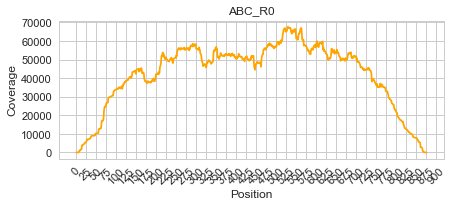

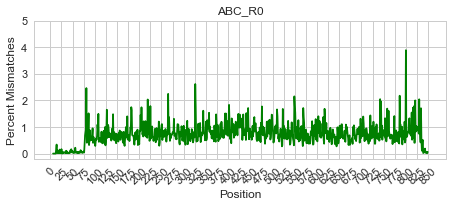

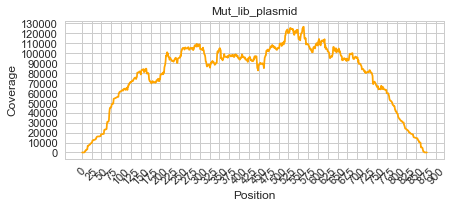

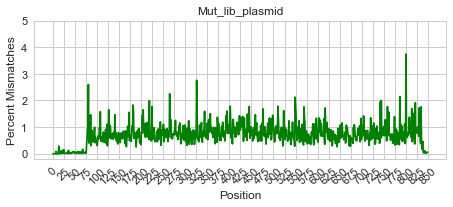

In [43]:
for sample in starting_samples:
    df = pd.read_csv(position_data_tables[sample], sep='\t')
    df = norm_position_df(df)
    summary = df.describe()
    summary.to_csv('../data/tables/%s_summary_stats_pos.tsv' %
                   sample, sep='\t')
    fig, ax  = plot_single_rep_coverage(df, sample)
    ax
    fig, ax = plot_single_rep_mutation_rate(df[df['pos']<850], sample)
    ax

Here I produce some summary statistics for the region under mutagenesis.

In [44]:
df = pd.read_csv(position_data_tables['ABC_R0'], sep='\t')
df = norm_position_df(df)
describe_df = df[(df['pos'] >= 74) & (df['pos'] <=841)].describe()
describe_df.loc['stde'] = describe_df.loc['std']/np.sqrt(describe_df.loc['count'])
describe_df.to_csv('../data/tables/ABC_R0_summary_stats_pos_74-841.tsv')
DataTable(describe_df)

pos,reads_all,matches,mismatches,deletions,insertions,A,T,C,G,N
768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
457.500000,47210.197917,99.189074,0.789452,0.021474,0.003049,36.046710,25.741924,17.912214,20.277375,0.000302
221.846794,12003.249212,0.372126,0.366167,0.063680,0.014860,47.536489,43.234675,37.967445,39.796681,0.000830
74.000000,9760.000000,96.115216,0.019948,0.000000,0.000000,0.000000,0.010246,0.000000,0.000000,0.000000
265.750000,40365.500000,99.043312,0.554113,0.000000,0.000000,0.256901,0.249467,0.043199,0.058315,0.000000
457.500000,50484.000000,99.258478,0.717261,0.002026,0.000000,0.501980,0.395493,0.156064,0.250302,0.000000
649.250000,55352.750000,99.424362,0.926002,0.010114,0.001540,99.211924,98.653868,0.372939,0.447223,0.000000
841.000000,67606.000000,99.970078,3.884784,0.770075,0.277677,99.959807,99.970078,99.616731,99.959787,0.007884
8.005207,433.129948,0.013428,0.013213,0.002298,0.000536,1.715325,1.560097,1.370032,1.436039,0.000030


In [45]:
df = pd.read_csv(position_data_tables['Mut_lib_plasmid'], sep='\t')
df = norm_position_df(df)
describe_df = df[(df['pos'] >= 74) & (df['pos'] <=841)].describe()
describe_df.loc['stde'] = describe_df.loc['std']/np.sqrt(describe_df.loc['count'])
describe_df.to_csv('../data/tables/Mut_lib_plasmid_summary_stats_pos_74-841.tsv')
DataTable(describe_df)

pos,reads_all,matches,mismatches,deletions,insertions,A,T,C,G,N
768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
457.500000,87845.578125,99.193482,0.784659,0.021859,0.003129,36.045942,25.740883,17.915073,20.275998,0.000245
221.846794,22848.409768,0.367813,0.362258,0.064040,0.015403,47.538955,43.236886,37.971587,39.799065,0.000541
74.000000,18089.000000,96.258263,0.024703,0.000000,0.000000,0.005437,0.006588,0.006164,0.005394,0.000000
265.750000,74856.750000,99.043033,0.554986,0.000000,0.000000,0.259461,0.253541,0.043335,0.057633,0.000000
457.500000,94169.500000,99.257504,0.719641,0.002212,0.000000,0.484307,0.392098,0.156924,0.248687,0.000000
649.250000,104073.250000,99.419943,0.935732,0.009494,0.001219,99.212080,98.707933,0.379724,0.449123,0.000000
841.000000,126576.000000,99.975297,3.741737,0.772301,0.305581,99.969257,99.951456,99.634108,99.975297,0.005171
8.005207,824.470971,0.013272,0.013072,0.002311,0.000556,1.715414,1.560177,1.370182,1.436125,0.000020


## Data Table Manipulation

In this section I load in all of the time serious data, using the function merge_data_frames.

In [46]:
m_df = merge_data_frames(position_data_tables, time_course_samples)
m_df = m_df[m_df['pos'] > 73]
m_df = m_df[m_df['pos'] <= 841]
m_df = add_protein_data(m_df)
m_df.to_excel('../data/tables/annotated_rap1_mutation_data.xls')
m_df.to_html('../data/tables/annotated_rap1_mutation_data.html')

Next I get the shared decreasing position across rounds. These are defined as positions with mismatches that either decrease or stay the same from each round to the next in all three replicates.

In [47]:
shared_positions = get_shared_decreasing_positions(m_df,round_reg='%s_R[0-5]-mismatches')
print(sorted(list(shared_positions)))
sdp_df = m_df[m_df['pos'].isin(shared_positions)]
sdp_df.to_excel('../data/tables/annotated_shared_decreasing_positions.xls')
sdp_df.to_html('../data/tables/annotated_shared_decreasing_positions.html')

44
43
54
[255, 263, 264, 266, 267, 275, 277, 279, 291, 392, 714, 722, 726, 732, 744, 750, 768, 777, 780, 807]


Here I attempted to identify any positions that end with zero mismatches. There are no positions that meet this requirement in any of the three replicates.

In [48]:
zero_positions = []
for c in 'ABC':
    r1 = '%s_R1-mismatches' % c
    r2 = '%s_R5-mismatches' % c
    z = m_df[m_df[r2] == 0.0]
    zero_positions.extend(list(z['pos']))

zero_positions = list(set(zero_positions))
print(zero_positions)
zp = m_df[m_df['pos'].isin(zero_positions)]
zp.to_excel('../data/tables/annotated_zero_ending_positions.xls')
zp.to_html('../data/tables/annotated_zero_ending_positions.html')

[]


This function takes a set of positions and returns data for all codon members for those positions

In [49]:
def make_codon_table(df, positions):
    df_list = []
    for position in positions:
        idx = int(df[df.pos == position].index[0])

        codon_pos = int(df['codon_positions'].loc[idx])
        if codon_pos==1:

            df_list.append(df.loc[idx:idx + 2])
            
        if codon_pos==2:

            df_list.append(df.loc[idx-1:idx+1])
        
        if codon_pos==3:

            df_list.append(df.loc[idx-2:idx])
    
    return pd.concat(df_list).drop_duplicates()

Lili was most interested in the shared decreasing position that were less position 400

In [50]:
lili_positions = [x for x in shared_positions if x < 400]
print(lili_positions)

[291, 263, 264, 392, 266, 267, 275, 277, 279, 255]


I  next used the make_codon_table function to generate the table with all codon members corresponding to Lili's list.

In [51]:
lili_table = make_codon_table(m_df, list(lili_positions))
lili_table = lili_table.sort_values('pos').reset_index()
DataTable(lili_table)

index,chrom,pos,ref,B_R1-reads_all,B_R1-matches,B_R1-mismatches,B_R1-deletions,B_R1-insertions,B_R1-A,B_R1-T,B_R1-C,B_R1-G,B_R1-N,A_R4-reads_all,A_R4-matches,A_R4-mismatches,A_R4-deletions,A_R4-insertions,A_R4-A,A_R4-T,A_R4-C,A_R4-G,A_R4-N,A_R2-reads_all,A_R2-matches,A_R2-mismatches,A_R2-deletions,A_R2-insertions,A_R2-A,A_R2-T,A_R2-C,A_R2-G,A_R2-N,C_R3-reads_all,C_R3-matches,C_R3-mismatches,C_R3-deletions,C_R3-insertions,C_R3-A,C_R3-T,C_R3-C,C_R3-G,C_R3-N,C_R4-reads_all,C_R4-matches,C_R4-mismatches,C_R4-deletions,C_R4-insertions,C_R4-A,C_R4-T,C_R4-C,C_R4-G,C_R4-N,B_R3-reads_all,B_R3-matches,B_R3-mismatches,B_R3-deletions,B_R3-insertions,B_R3-A,B_R3-T,B_R3-C,B_R3-G,B_R3-N,C_R5-reads_all,C_R5-matches,C_R5-mismatches,C_R5-deletions,C_R5-insertions,C_R5-A,C_R5-T,C_R5-C,C_R5-G,C_R5-N,B_R4-reads_all,B_R4-matches,B_R4-mismatches,B_R4-deletions,B_R4-insertions,B_R4-A,B_R4-T,B_R4-C,B_R4-G,B_R4-N,C_R1-reads_all,C_R1-matches,C_R1-mismatches,C_R1-deletions,C_R1-insertions,C_R1-A,C_R1-T,C_R1-C,C_R1-G,C_R1-N,B_R5-reads_all,B_R5-matches,B_R5-mismatches,B_R5-deletions,B_R5-insertions,B_R5-A,B_R5-T,B_R5-C,B_R5-G,B_R5-N,C_R2-reads_all,C_R2-matches,C_R2-mismatches,C_R2-deletions,C_R2-insertions,C_R2-A,C_R2-T,C_R2-C,C_R2-G,C_R2-N,A_R1-reads_all,A_R1-matches,A_R1-mismatches,A_R1-deletions,A_R1-insertions,A_R1-A,A_R1-T,A_R1-C,A_R1-G,A_R1-N,B_R2-reads_all,B_R2-matches,B_R2-mismatches,B_R2-deletions,B_R2-insertions,B_R2-A,B_R2-T,B_R2-C,B_R2-G,B_R2-N,ABC_R0-reads_all,ABC_R0-matches,ABC_R0-mismatches,ABC_R0-deletions,ABC_R0-insertions,ABC_R0-A,ABC_R0-T,ABC_R0-C,ABC_R0-G,ABC_R0-N,A_R5-reads_all,A_R5-matches,A_R5-mismatches,A_R5-deletions,A_R5-insertions,A_R5-A,A_R5-T,A_R5-C,A_R5-G,A_R5-N,A_R3-reads_all,A_R3-matches,A_R3-mismatches,A_R3-deletions,A_R3-insertions,A_R3-A,A_R3-T,A_R3-C,A_R3-G,A_R3-N,a_cod,t_cod,g_cod,c_cod,a_aa,t_aa,g_aa,c_aa,codon_positions
253,PCR,254,G,104030,99.375180,0.624820,0.000000,0.000000,0.386427,0.127848,0.110545,99.375180,0.000000,99747,99.787462,0.212538,0.000000,0.000000,0.150380,0.036091,0.026066,99.787462,0.000000,75101,99.601869,0.398131,0.000000,0.000000,0.250330,0.077229,0.070572,99.601869,0.000000,105528,99.794367,0.204685,0.000948,0.000000,0.143090,0.036957,0.024638,99.794367,0.000000,109822,99.778733,0.221267,0.000000,0.000911,0.142048,0.044618,0.034601,99.778733,0.000000,116794,99.761974,0.238026,0.000000,0.000000,0.160967,0.049660,0.027399,99.761974,0.000000,120331,99.844595,0.155405,0.000000,0.000000,0.105542,0.025762,0.024100,99.844595,0.000000,110474,99.754693,0.244401,0.000905,0.000000,0.172891,0.035302,0.035302,99.754693,0.000905,124423,99.381947,0.618053,0.000000,0.000000,0.368099,0.133416,0.115734,99.381947,0.000804,120957,99.849533,0.150467,0.000000,0.000000,0.101689,0.028936,0.019842,99.849533,0.000000,153234,99.621494,0.378506,0.000000,0.000000,0.230367,0.080922,0.067217,99.621494,0.000000,107172,99.438286,0.561714,0.000000,0.000933,0.320979,0.115702,0.124100,99.438286,0.000933,79908,99.520699,0.478050,0.001251,0.000000,0.277819,0.110127,0.090104,99.520699,0.000000,54596,99.135468,0.864532,0.000000,0.000000,0.501868,0.203312,0.159352,99.135468,0.000000,88494,99.845187,0.154813,0.000000,0.000000,0.113002,0.024860,0.015820,99.845187,0.001130,113422,99.791046,0.208073,0.000882,0.000000,0.141948,0.033503,0.031740,99.791046,0.000882,AAT,TAT,GAT,CAT,N,Y,D,H,1
254,PCR,255,A,105895,99.432457,0.567543,0.000000,0.000000,99.432457,0.269135,0.036829,0.261580,0.000000,101613,99.841556,0.158444,0.000000,0.000000,99.841556,0.069873,0.007873,0.080698,0.000000,76409,99.663652,0.335039,0.001309,0.000000,99.663652,0.150506,0.018322,0.166211,0.000000,107250,99.809790,0.189277,0.000932,0.000000,99.809790,0.066200,0.013986,0.109091,0.000000,111779,99.820181,0.178924,0.000895,0.000000,99.820181,0.067991,0.015209,0.095725,0.000000,118740,99.818932,0.180226,0.000842,0.000000,99.818932,0.077480,0.010106,0.092639,0.000000,122240,99.887925,0.112075,0.000000,0.000000,99.887925,0.041721,0.016361,0.053174,0.000818,112486,99.861316,0.138

In [52]:
lili_table.columns.tolist()

['index',
 'chrom',
 'pos',
 'ref',
 'B_R1-reads_all',
 'B_R1-matches',
 'B_R1-mismatches',
 'B_R1-deletions',
 'B_R1-insertions',
 'B_R1-A',
 'B_R1-T',
 'B_R1-C',
 'B_R1-G',
 'B_R1-N',
 'A_R4-reads_all',
 'A_R4-matches',
 'A_R4-mismatches',
 'A_R4-deletions',
 'A_R4-insertions',
 'A_R4-A',
 'A_R4-T',
 'A_R4-C',
 'A_R4-G',
 'A_R4-N',
 'A_R2-reads_all',
 'A_R2-matches',
 'A_R2-mismatches',
 'A_R2-deletions',
 'A_R2-insertions',
 'A_R2-A',
 'A_R2-T',
 'A_R2-C',
 'A_R2-G',
 'A_R2-N',
 'C_R3-reads_all',
 'C_R3-matches',
 'C_R3-mismatches',
 'C_R3-deletions',
 'C_R3-insertions',
 'C_R3-A',
 'C_R3-T',
 'C_R3-C',
 'C_R3-G',
 'C_R3-N',
 'C_R4-reads_all',
 'C_R4-matches',
 'C_R4-mismatches',
 'C_R4-deletions',
 'C_R4-insertions',
 'C_R4-A',
 'C_R4-T',
 'C_R4-C',
 'C_R4-G',
 'C_R4-N',
 'B_R3-reads_all',
 'B_R3-matches',
 'B_R3-mismatches',
 'B_R3-deletions',
 'B_R3-insertions',
 'B_R3-A',
 'B_R3-T',
 'B_R3-C',
 'B_R3-G',
 'B_R3-N',
 'C_R5-reads_all',
 'C_R5-matches',
 'C_R5-mismatches',
 'C_R5-d

In [53]:
lili_table_mismatch_only = lili_table.filter(regex = ('pos|ref|mismatches|.*_cod|.*_aa|codon_positions'))
#lili_table_mutations_only.filter(regex = ('mismatches'))
for i in range(1,6):
    lili_table_mismatch_only['avg_R%s-mismatches'%str(i)] = lili_table_mismatch_only.filter(regex=('.*_R%s-mismatches'%str(i))).mean(axis = 1,skipna=True)
    lili_table_mismatch_only['std_R%s-mismatches'%str(i)] = lili_table_mismatch_only.filter(regex=('.*_R%s-mismatches'%str(i))).std(axis = 1,skipna=True)
lili_table_mismatch_only = lili_table_mismatch_only.sort_values(by='pos')
lili_table_mismatch_only.to_excel('../data/tables/lili_table_mismatch_only.xls')
lili_table_mismatch_only.to_html('../data/tables/lili_table_mismatch_only.html')
DataTable(lili_table_mismatch_only.filter(regex = ('mismatches|pos')))

pos,B_R1-mismatches,A_R4-mismatches,A_R2-mismatches,C_R3-mismatches,C_R4-mismatches,B_R3-mismatches,C_R5-mismatches,B_R4-mismatches,C_R1-mismatches,B_R5-mismatches,C_R2-mismatches,A_R1-mismatches,B_R2-mismatches,ABC_R0-mismatches,A_R5-mismatches,A_R3-mismatches,codon_positions,avg_R1-mismatches,std_R1-mismatches,avg_R2-mismatches,std_R2-mismatches,avg_R3-mismatches,std_R3-mismatches,avg_R4-mismatches,std_R4-mismatches,avg_R5-mismatches,std_R5-mismatches
254,0.624820,0.212538,0.398131,0.204685,0.221267,0.238026,0.155405,0.244401,0.618053,0.150467,0.378506,0.561714,0.478050,0.864532,0.154813,0.208073,1,0.601529,0.028289,0.418229,0.043052,0.216928,0.014983,0.226069,0.013444,0.153561,0.002202
255,0.567543,0.158444,0.335039,0.189277,0.178924,0.180226,0.112075,0.138684,0.476514,0.114681,0.346556,0.522361,0.378095,0.668932,0.116595,0.192538,2,0.522139,0.037163,0.353230,0.018200,0.187347,0.005208,0.158684,0.016429,0.114450,0.001853
256,0.623963,0.495225,0.560740,0.503565,0.497637,0.438685,0.472168,0.482903,0.604696,0.476829,0.494831,0.582709,0.563933,0.628005,0.506635,0.436526,3,0.603789,0.016854,0.539835,0.031849,0.459592,0.031106,0.491922,0.006453,0.485211,0.015268
263,0.706406,0.298211,0.513046,0.348639,0.337060,0.416084,0.294937,0.322924,0.673204,0.286482,0.508376,0.692700,0.574181,0.835630,0.274081,0.381241,1,0.690770,0.013623,0.531868,0.029981,0.381988,0.027539,0.319398,0.016055,0.285167,0.008565
264,0.581882,0.309252,0.463511,0.356313,0.296154,0.353080,0.230388,0.268796,0.597263,0.238689,0.450587,0.564765,0.476918,0.716007,0.259199,0.316596,2,0.581303,0.013274,0.463672,0.010751,0.341996,0.018009,0.291401,0.016855,0.242759,0.012109
265,2.240312,2.402411,2.260131,2.216813,2.284508,2.193962,2.279298,2.330059,2.338639,2.337928,2.151758,2.210462,2.255805,2.242241,2.382780,2.280582,3,2.263138,0.054760,2.222565,0.050099,2.230453,0.036654,2.338993,0.048547,2.333335,0.042371
266,0.606404,0.143610,0.362546,0.167977,0.156661,0.186635,0.104023,0.143142,0.628431,0.098513,0.363662,0.569693,0.388321,0.840788,0.118209,0.181175,1,0.601509,0.024228,0.371510,0.011896,0.178596,0.007832,0.147804,0.006265,0.106915,0.008297
267,0.929917,0.179941,0.572624,0.264149,0.219432,0.304860,0.144026,0.240814,0.939728,0.152901,0.545936,0.846157,0.599133,1.367188,0.113684,0.226389,2,0.905267,0.041989,0.572564,0.021718,0.265133,0.032043,0.213396,0.025215,0.136871,0.016791
268,0.770751,0.526742,0.638705,0.518821,0.496162,0.510126,0.548720,0.562303,0.736530,0.560201,0.603654,0.671908,0.667340,0.891605,0.572967,0.544383,3,0.726397,0.040984,0.636566,0.026043,0.524444,0.014540,0.528402,0.027028,0.560629,0.009903
275,0.474666,0.083582,0.226027,0.118538,0.096565,0.136097,0.052371,0.101480,0.454269,0.069879,0.228508,0.401166,0.257557,0.797113,0.073807,0.106162,1,0.443367,0.030981,0.237364,0.014315,0.120266,0.012282,0.093876,0.007551,0.065352,0.009318


Here I filter for the columns that were specifically asked for by Lili.

In [54]:
lili_table_with_details = lili_table.filter(regex = ('pos|ref|R0.*mismatches|[ABC]_R0.*[ATGC]|R5.*[ATGC]|R5.*mismatches|R10.*[ATGC]|R10.*mismatches|.*_cod|.*_aa|codon_positions'))
lili_table_with_details.columns

Index(['pos', 'ref', 'C_R5-mismatches', 'C_R5-A', 'C_R5-T', 'C_R5-C', 'C_R5-G',
       'B_R5-mismatches', 'B_R5-A', 'B_R5-T', 'B_R5-C', 'B_R5-G',
       'ABC_R0-mismatches', 'ABC_R0-A', 'ABC_R0-T', 'ABC_R0-C', 'ABC_R0-G',
       'A_R5-mismatches', 'A_R5-A', 'A_R5-T', 'A_R5-C', 'A_R5-G', 'a_cod',
       't_cod', 'g_cod', 'c_cod', 'a_aa', 't_aa', 'g_aa', 'c_aa',
       'codon_positions'],
      dtype='object')

Next I added averages across replicates or round 5, and wrote the table out.

In [55]:
lili_table_with_details['avg_R5_mismatches'] = lili_table_with_details.filter(regex=('[ABC]_R5-mismatches')).mean(axis = 1,skipna=True)
lili_table_with_details['avg_R5-A'] = lili_table_with_details.filter(regex=('[ABC]_R5-A')).mean(axis = 1,skipna=True)
lili_table_with_details['avg_R5-T'] = lili_table_with_details.filter(regex=('[ABC]_R5-T')).mean(axis = 1,skipna=True)
lili_table_with_details['avg_R5-C'] = lili_table_with_details.filter(regex=('[ABC]_R5-C')).mean(axis = 1,skipna=True)
lili_table_with_details['avg_R5-G'] = lili_table_with_details.filter(regex=('[ABC]_R5-G')).mean(axis = 1,skipna=True)
lili_table_with_details = lili_table_with_details.sort_values(by = 'pos')
lili_table_with_details.to_excel('../data/tables/lili_table_with_details.xls')
lili_table_with_details.to_html('../data/tables/lili_table_with_details.html')
DataTable(lili_table_with_details.filter(regex=('mismatches')))

C_R5-mismatches,B_R5-mismatches,ABC_R0-mismatches,A_R5-mismatches,avg_R5_mismatches
0.155405,0.150467,0.864532,0.154813,0.153561
0.112075,0.114681,0.668932,0.116595,0.114450
0.472168,0.476829,0.628005,0.506635,0.485211
0.294937,0.286482,0.835630,0.274081,0.285167
0.230388,0.238689,0.716007,0.259199,0.242759
2.279298,2.337928,2.242241,2.382780,2.333335
0.104023,0.098513,0.840788,0.118209,0.106915
0.144026,0.152901,1.367188,0.113684,0.136871
0.548720,0.560201,0.891605,0.572967,0.560629
0.052371,0.069879,0.797113,0.073807,0.065352


Here I used the function get_shared_r_zero_decreased_positions to get all position that had lower mismatch rates at round 5 verse round zero.

In [56]:
r_zero_decreased_positions = get_shared_r_zero_decreased_positions(m_df)
r_zero_decreased_positions

{76,
 78,
 82,
 83,
 84,
 85,
 86,
 88,
 89,
 90,
 93,
 99,
 100,
 102,
 105,
 106,
 110,
 114,
 115,
 117,
 118,
 122,
 126,
 129,
 130,
 131,
 132,
 134,
 135,
 136,
 137,
 139,
 140,
 141,
 144,
 146,
 147,
 149,
 150,
 156,
 158,
 161,
 163,
 164,
 165,
 168,
 170,
 171,
 172,
 174,
 175,
 176,
 179,
 180,
 181,
 184,
 185,
 186,
 189,
 191,
 192,
 194,
 195,
 198,
 199,
 200,
 201,
 203,
 204,
 205,
 206,
 207,
 209,
 210,
 211,
 214,
 217,
 223,
 226,
 227,
 229,
 230,
 231,
 232,
 233,
 234,
 236,
 237,
 239,
 240,
 242,
 245,
 246,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 260,
 261,
 262,
 263,
 264,
 266,
 267,
 268,
 269,
 270,
 271,
 272,
 274,
 275,
 276,
 277,
 278,
 279,
 281,
 283,
 284,
 285,
 287,
 290,
 291,
 292,
 293,
 294,
 295,
 296,
 297,
 300,
 305,
 308,
 310,
 311,
 312,
 314,
 315,
 317,
 318,
 319,
 320,
 323,
 327,
 332,
 333,
 334,
 337,
 339,
 342,
 344,
 346,
 348,
 355,
 358,
 359,
 362,
 365,
 370,
 373,
 374,
 377,
 380,
 381

## Venn Diagrams

Here I plot a venn diagram of positions that have mismatch percentages that decrease or stay the same in every round comparing each replicate.

44
43
54
20


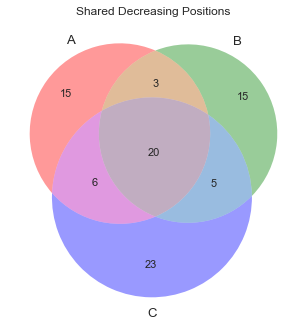

In [57]:
plot_shared_decreasing_ven(m_df)

Here I plot a venn diagram of positions that have mismatch percentages that decrease in round 5 relative to round zero comparing each replicate.

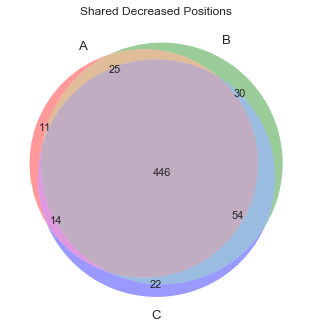

In [58]:
plot_shared_decreased_ven(m_df)

## Mismatch Percentage Timecourse for Shared Decreasing Positions

In this section I visualize the shared decreasing positions for each replicate.

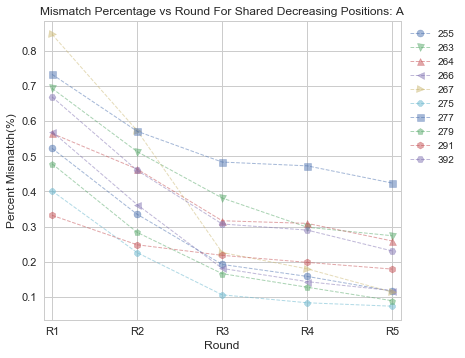

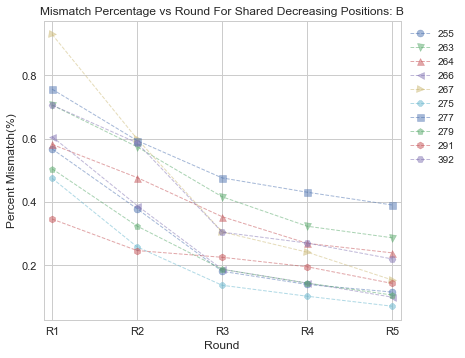

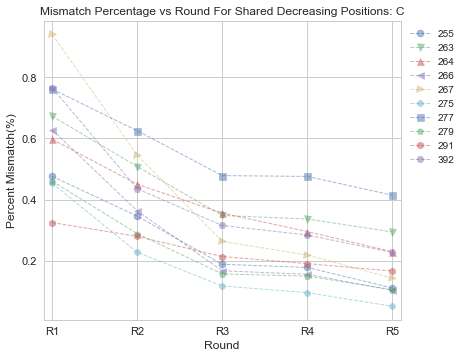

In [59]:
for e in ['A', 'B', 'C']:
    plot_time_course_mismatches(m_df, positions=lili_positions, exp=e)


## Analysis and Figures for Paper

This section contains analysis that I did nearly a year after the initial experiment. It less formalized and contains some reformating of data that I did on the fly, rather than make specific functions. The figures in this experiment are meant to be publication material, rather than presentation(which are what the previous sections figures are used for).

### Summarizing effect of codon position on average fold change

Here I am examining the effect of codon position on fold change. Third codon position wobble allows for variety of nucleotides being present at the third position which all lead to the same amino acid incorporation.

In [64]:
x, mean_fc, ste_fc = make_round_zero_comparisons(m_df,rnd=5)
fold_changes = x.filter(regex=('avg_.*-fc_mismatches'))

In [65]:
data = x.filter(regex=('[ABC]_R0R5-fc_mismatches|codon*'))
data_list = []
for c in 'ABC':
    df = pd.DataFrame()
    df['codon_positions'] = data['codon_positions']
    df['fc_mismatches'] = data['%s_R0R5-fc_mismatches' % c]
    df['replicate'] = c
    data_list.append(df)

tall_data = pd.concat(data_list)
tall_data.head()

,codon_positions,fc_mismatches,replicate
73,1,1.228668,A
74,2,0.863995,A
75,3,1.433476,A
76,1,0.976768,A
77,2,1.236631,A


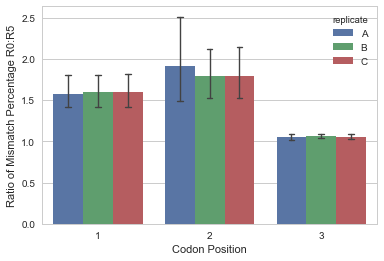

In [66]:
ax = sns.barplot(x='codon_positions', y='fc_mismatches', hue='replicate', data=tall_data, ci=95, capsize=0.05, errwidth=1.4)
ax.set_ylabel('Ratio of Mismatch Percentage R0:R5')
ax.set_xlabel('Codon Position')

Next  I wanted to re-make the venn diagrams sized for a paper.

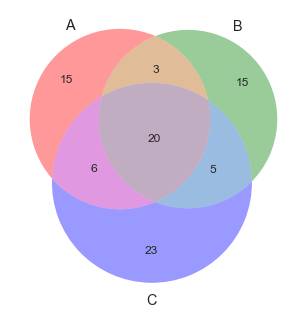

In [69]:
df = m_df
shared_decr_pos_dict = defaultdict(list)
for a in ['A', 'B', 'C']:
    for position in df['pos']:
        x = df[df['pos'] == position]
        x_values = x.filter(regex=('%s_R[0-5]-mismatches' % a))
        x_values = x_values.sort_index(axis=1)
        if row_column_checker(x_values):
            shared_decr_pos_dict[a].append(position)

fig = plt.figure(1, figsize=(5.5, 5.5))
plt.style.use('seaborn-whitegrid')
matplotlib.rcParams.update({'font.size': majorFontSize})
v.venn3([set(l) for l in shared_decr_pos_dict.values()],
        shared_decr_pos_dict.keys(), alpha=0.4)
fig.savefig('../fig/paper_figures/SupplementalFigureVennOnly.pdf')

In [76]:
DataTable(all_rounds_fc[all_rounds_fc['pos'].isin(shared_positions)].filter(regex='{}_.*'.format('A')).sort_index(axis=1))

A_R0R1-fc_mismatches,A_R0R2-fc_mismatches,A_R0R3-fc_mismatches,A_R0R4-fc_mismatches,A_R0R5-fc_mismatches
1.280595,1.996580,3.474290,4.221878,5.737210
1.206338,1.628761,2.191870,2.802145,3.048841
1.267797,1.544746,2.261581,2.315287,2.762381
1.475862,2.319118,4.640744,5.854649,7.112750
1.615760,2.387584,6.039115,7.597976,12.026157
1.986992,3.526623,7.508477,9.536943,10.800038
1.135027,1.456362,1.719928,1.758988,1.962173
1.402929,2.366509,4.036033,5.255377,7.503961
1.030579,1.377654,1.567183,1.724750,1.908464
1.456974,2.118540,3.167835,3.357082,4.220379


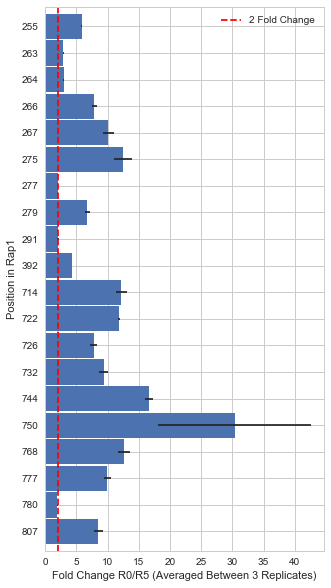

In [78]:
fig, ax = plt.subplots(figsize=(5,10))
ax = avg_rounds_fc[avg_rounds_fc['pos'].isin(shared_positions)].plot('pos', 
                                                                     'avg_R0R5-fc_mismatches',  
                                                                     kind='barh',
                                                                     xerr='ste_R0R5-fc_mismatches',
                                                                     width=0.95,
                                                                     legend=False,
                                                                     label='_nolegend_',
                                                                     ax=ax,)
ax.vlines(x=2, 
          ymin=ax.get_ylim()[0], 
          ymax=ax.get_ylim()[1],
          color='red',
          linestyle='--',
          label='2 Fold Change'
)
ax.legend()
ax.set_xlabel('Fold Change R0/R5 (Averaged Between 3 Replicates)')
ax.set_ylabel('Position in Rap1')
ax.invert_yaxis()
fig.savefig('../fig/paper_figures/SupplementalFigureSimpleBar.pdf',bbox_inches='tight')


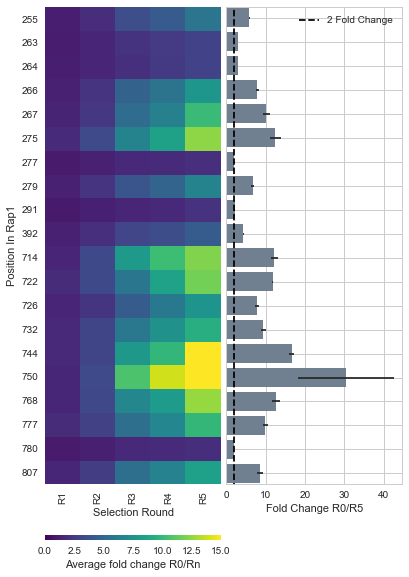

In [79]:
fig=plt.figure(figsize=(6.4,9.8))
fig.subplots_adjust(hspace=5.0,wspace=0.03)
gs = gridspec.GridSpec(20, 2)
ax = plt.subplot(gs[0:18, 0])
ax2 = plt.subplot(gs[0:18, 1])
cbar_ax = plt.subplot(gs[19, 0])

ax = sns.heatmap(avg_rounds_fc[avg_rounds_fc['pos'].isin(shared_positions)].filter(regex='avg_.*'), 
                 cmap='viridis', 
                 yticklabels=sorted(list(shared_positions)), 
                 vmax=15,
                 vmin=0,
                  #robust=True,
                #linewidths=1e-14,
                 cbar=True,
                 cbar_ax = cbar_ax,
                 cbar_kws={'label': 'Average fold change R0/Rn', 
                           'orientation':'horizontal'},
                  ax=ax,
)

labels = [x.get_text().split('-')[0].split('_')[1].replace('R0', '') 
          for x in ax.get_xticklabels()
         ]

ax.set_xticklabels(labels, fontsize=minorFontSize -1)
ax.set_xlabel('Selection Round', fontsize=minorFontSize)
ax.set_ylabel('Position In Rap1', fontsize=minorFontSize)
ax.set_yticklabels(ax.get_yticklabels(), 
                    rotation = 0)



ax2 = avg_rounds_fc[avg_rounds_fc['pos'].isin(shared_positions)].plot('pos', 
                                                                     'avg_R0R5-fc_mismatches',  
                                                                     kind='barh',
                                                                     xerr='ste_R0R5-fc_mismatches',
                                                                     color='slategrey',
                                                                     width=0.8,
                                                                     legend=False,
                                                                     label='_nolegend_',
                                                                     ax=ax2,)
ax2.vlines(x=2, 
          ymin=ax.get_ylim()[0] -10, 
          ymax=ax.get_ylim()[1] + 10,
          color='black',
          linestyle='--',
          label='2 Fold Change'
)
ax2.legend()
ax2.set_xlabel('Fold Change R0/R5')
ax2.set_ylabel('')
ax2.set_yticklabels(['' for _ in ax2.get_yticklabels()])
ax2.set_ylim(ax2.get_ylim()[0] + .2,
             ax2.get_ylim()[1] - 0.2 ,
            )
ax2.invert_yaxis()
fig.savefig('../fig/paper_figures/SupplementalFigureSubHeatWithSimpleBar.pdf',bbox_inches='tight')

In [80]:
shared_decr_codon_table = make_codon_table(m_df, list(shared_positions))
print(list(shared_decr_codon_table.columns))
shared_decr_codon_table['codon'] = shared_decr_codon_table.apply(lambda x: x['{}_cod'.format(x['ref'].lower())],axis=1)
shared_decr_codon_table['amino_acid'] = shared_decr_codon_table.apply(lambda x: x['{}_aa'.format(x['ref'].lower())],axis=1)

['chrom', 'pos', 'ref', 'B_R1-reads_all', 'B_R1-matches', 'B_R1-mismatches', 'B_R1-deletions', 'B_R1-insertions', 'B_R1-A', 'B_R1-T', 'B_R1-C', 'B_R1-G', 'B_R1-N', 'A_R4-reads_all', 'A_R4-matches', 'A_R4-mismatches', 'A_R4-deletions', 'A_R4-insertions', 'A_R4-A', 'A_R4-T', 'A_R4-C', 'A_R4-G', 'A_R4-N', 'A_R2-reads_all', 'A_R2-matches', 'A_R2-mismatches', 'A_R2-deletions', 'A_R2-insertions', 'A_R2-A', 'A_R2-T', 'A_R2-C', 'A_R2-G', 'A_R2-N', 'C_R3-reads_all', 'C_R3-matches', 'C_R3-mismatches', 'C_R3-deletions', 'C_R3-insertions', 'C_R3-A', 'C_R3-T', 'C_R3-C', 'C_R3-G', 'C_R3-N', 'C_R4-reads_all', 'C_R4-matches', 'C_R4-mismatches', 'C_R4-deletions', 'C_R4-insertions', 'C_R4-A', 'C_R4-T', 'C_R4-C', 'C_R4-G', 'C_R4-N', 'B_R3-reads_all', 'B_R3-matches', 'B_R3-mismatches', 'B_R3-deletions', 'B_R3-insertions', 'B_R3-A', 'B_R3-T', 'B_R3-C', 'B_R3-G', 'B_R3-N', 'C_R5-reads_all', 'C_R5-matches', 'C_R5-mismatches', 'C_R5-deletions', 'C_R5-insertions', 'C_R5-A', 'C_R5-T', 'C_R5-C', 'C_R5-G', 'C_R5-

In [81]:
figure_table = shared_decr_codon_table[shared_decr_codon_table['pos'].isin(shared_positions)].filter(regex='pos|ref|codon|amino').sort_values('pos').reset_index(drop=True)
figure_table.columns = ['Position', 'WT', 'Codon Position', 'Codon', 'Amino Acid']
figure_table.to_excel('../fig/paper_figures/SharedCodonAaTable.xls',index=False)
DataTable(figure_table)

Position,WT,Codon Position,Codon,Amino Acid
255,A,2,GAT,D
263,G,1,GCT,A
264,C,2,GCT,A
266,T,1,TTT,F
267,T,2,TTT,F
275,C,1,CAA,Q
277,A,3,CAA,Q
279,T,2,GTG,V
291,A,2,TAC,Y
392,T,1,TTT,F
